## Word 2 Vec feature based on Playlist Name

#### Motivation:
This notebook will walk through the construction of our 209-level feature.  We will apply a word-to-vec transform to as many applicable words as there are in the set of playlist names.  The core intuition behind this, is that the playlist name is what represents the playlist to the outside world.  A bad playlist name can keep people from following or listening to it, even if the content is great.  

#### Techique:
This exercise seeks to cluster the playlist names into meaningful categories based on the sum of the vectors of known words in the playlist.  This will implicitly seperate playlists with longer (presumably more informative) names by giving them a total higher magnitude in the 100-dimensional space of our word-to-vec transform, but this seems to be a good aggregation technique.  

#### Difficulties:
Ultimately, there will be some difficulties with misspellings, different languages, and internet slang, and we will doubtless lose information in this quick application of word-to-vec, but we think the output will still be a meaningful feature in our final model.

In [2]:
# Imports
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import utils
from gensim.models.word2vec import Word2Vec, KeyedVectors
import html
import re
import itertools
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from scipy.spatial.distance import cdist

sns.set_context('paper')
sns.set_style('white')
sns.color_palette('muted')
%matplotlib inline

In [3]:
# Get the data
current_df = utils.make_working_df()
current_df.head()

,trk_added_at,art_name,trk_duration,explicit,trk_id,trk_name,pl_id,trk_popularity,artist_followers,artist_genre,...,pl_min_trkpop,pl_max_trkpop,pl_mean_trkpop,art_min_trkpop,art_max_trkpop,art_mean_trkpop,art_total_trks,art_class,user_pls_in_sample,pl_desc_chars
0,2013-09-30 16:12:24,Allgott & Villgott,119907.0,0.0,3aIptaHMnbIXRxPWKlqwc6,Klappa lamm,3ftsSOkyCsILZeAZYQr2jH,2.0,76.0,None,...,0.0,4.0,1.333333,0.0,6.0,1.764706,13,crap_factory,515,0
1,2013-10-05 15:22:13,Allgott & Villgott,67918.0,0.0,0rPBlDWP6wcfax63Vs8nAF,Hej på dej,3ftsSOkyCsILZeAZYQr2jH,4.0,76.0,None,...,0.0,4.0,1.333333,0.0,6.0,1.764706,13,crap_factory,515,0
2,2014-07-16 13:50:24,J Boog,217270.0,0.0,4RjHalDdUreXDJSJLo44lK,Sunshine Girl,35XFuuqgCvTYQARix7CFpm,53.0,103793.0,[polynesian pop],...,0.0,72.0,38.269231,0.0,58.0,38.419355,20,star,166,0
3,2014-07-06 09:12:01,Brennan Heart,222919.0,0.0,6A04TZRVZw8db1VsHeYOEx,Never Break Me - Toneshifterz Remix,0gGfciue2ZDCOG5uMv46gU,0.0,122496.0,[hardstyle],...,0.0,58.0,15.510000,0.0,47.0,11.272727,18,crap_factory,166,0
4,2012-06-29 11:53:52,Johnny Ray,153375.0,0.0,1k4p7c69Dkh2b7s813ooR8,"Yes Tonight, Josephine",6Tuex6CIDfZRyRtsmb5rwE,0.0,1281.0,None,...,0.0,0.0,0.000000,0.0,0.0,0.000000,1,garage_band,1731,0


In [4]:
len(current_df['pl_owner'].drop_duplicates())

846

In [5]:
len(current_df['pl_id'].drop_duplicates())

8183

In [6]:
pl_names = current_df[['pl_id','pl_name']].drop_duplicates()
print(len(pl_names))
pl_names.head()


8183


,pl_id,pl_name
0,3ftsSOkyCsILZeAZYQr2jH,Allgott o villgott
2,35XFuuqgCvTYQARix7CFpm,reggae
3,0gGfciue2ZDCOG5uMv46gU,Ηardstyle♬ WORLD OF HARDSTYLE | Wildstylez | N...
4,6Tuex6CIDfZRyRtsmb5rwE,50's Jukebox Hits
5,5xL1c6RCMhVDTVLZUsY5SR,Tina Mehrafzoon - Favoriter


#### Seperating the data

Now we have seperated the playlist names and realted id's from the rest of the data, and ensured the id's and names are unique.  We can move on to word-to-vec transformation now.

In [7]:
def clean_text(txt,flag='list'):
    txt = txt.lower()
    txt = html.unescape(txt)
    txt = ''.join(''.join(s)[:2] for _, s in itertools.groupby(txt))
    txt = re.sub('[^A-Za-z\s]+','',txt)
    txt = word_tokenize(txt)
    sw = set(stopwords.words('english'))
    ssw = set(stopwords.words('spanish'))
    out = []
    for word in txt:
        
        if word not in sw and word not in ssw:
            out.append(word)
            
    out = [w for w in out if w.strip()!='']
    if flag=='list':
        return out
    elif flag=='text':
        return ' '.join(out)


In [8]:
pl_names['clean_name'] = [clean_text(p) for p in pl_names['pl_name']]
print(len(pl_names))
pl_names.head()

8183


,pl_id,pl_name,clean_name
0,3ftsSOkyCsILZeAZYQr2jH,Allgott o villgott,"[allgott, villgott]"
2,35XFuuqgCvTYQARix7CFpm,reggae,[reggae]
3,0gGfciue2ZDCOG5uMv46gU,Ηardstyle♬ WORLD OF HARDSTYLE | Wildstylez | N...,"[ardstyle, world, hardstyle, wildstylez, noise..."
4,6Tuex6CIDfZRyRtsmb5rwE,50's Jukebox Hits,"[jukebox, hits]"
5,5xL1c6RCMhVDTVLZUsY5SR,Tina Mehrafzoon - Favoriter,"[tina, mehrafzoon, favoriter]"


### Load the pre-trained word-to-vec model

##### Model
Here we load in the pretrained word-to-vec model.  This model was trained with the Text8 wikipedia corpus.  This corpus seemed to be the most applicable one that was still a reasonable size to download to my personal computer and a reasonable time to train the model. After training the model, I added in the "sentences" formed by the playlist names to add several entries to the vocabulary of the model.  Without proper context the model will not denote a vector transform for a word, so there are still several words that do not have a related vector representation.  

##### Sub-optimal data for training
As you can see below, about 84% of the playlist names have at least one meaningful (not a stop word by NLTK standards) word that has a vector representation in our model.  This number could doubtless be improved with a music specific or more casual internet chat area like Twitter or Reddit dataset as opposed to the more formal Wikipedia dataset, but there is only so much time to make our features.

In [11]:
nwv = KeyedVectors.load('w2v/word2vec_model')

In [12]:
word_vectors = []
for w in pl_names['clean_name']:
    agg_vec = np.zeros(100)
    for n in w:
        try:
            agg_vec += nwv.word_vec(n) 
        except:
            pass
    word_vectors.append(agg_vec)

print('total playlists with names',len(word_vectors))
plists_w_vec_rep = len([w for w in word_vectors if not np.array_equal(w,np.zeros(100))])
print('total playlists as non-zero vectors',plists_w_vec_rep)
print('percentage of playlists with vector representation',plists_w_vec_rep/len(word_vectors))

total playlists with names 8183
total playlists as non-zero vectors 6835
percentage of playlists with vector representation 0.8352682390321398


In [13]:
pl_names['w2v'] = word_vectors
pl_names = pl_names.drop('clean_name',axis=1)
print(len(pl_names))
pl_names.head()

8183


,pl_id,pl_name,w2v
0,3ftsSOkyCsILZeAZYQr2jH,Allgott o villgott,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,35XFuuqgCvTYQARix7CFpm,reggae,"[-0.108421981335, 0.220556214452, 0.4266166985..."
3,0gGfciue2ZDCOG5uMv46gU,Ηardstyle♬ WORLD OF HARDSTYLE | Wildstylez | N...,"[2.51007777452, -2.81740119774, 0.297188825905..."
4,6Tuex6CIDfZRyRtsmb5rwE,50's Jukebox Hits,"[-1.95629256591, -0.241700597107, -0.581438588..."
5,5xL1c6RCMhVDTVLZUsY5SR,Tina Mehrafzoon - Favoriter,"[0.00500876270235, -0.0775637342595, -0.266624..."


In [14]:
X = np.array([i for i in pl_names['w2v']])
print(X.shape)

(8183, 100)


In [17]:
# Viz (takes a while to run)
# tsne5 = TSNE(perplexity=5).fit_transform(X)
# tsne10 = TSNE(perplexity=10).fit_transform(X)
# tsne15 = TSNE(perplexity=15).fit_transform(X)
# tsne20 = TSNE(perplexity=20).fit_transform(X)
# tsne30 = TSNE(perplexity=30).fit_transform(X)
# tsne40 = TSNE(perplexity=40).fit_transform(X)
tsne50 = TSNE(perplexity=50).fit_transform(X)

### Visualization in two dimensions using TSNE:

Here we present TSNE visualization in two dimensions at varying perplexity levels.  This gives a decent visualization of our data, but is still severly limited because we are going from 100 to 2 dimensions.

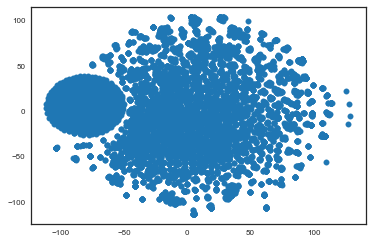

In [81]:
# perp=5
plt.scatter(tsne5[:,0],tsne5[:,1])
# plt.savefig('perp5')

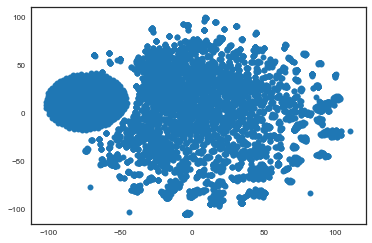

In [82]:
# perp=10
plt.scatter(tsne10[:,0],tsne10[:,1])
# plt.savefig('perp10')

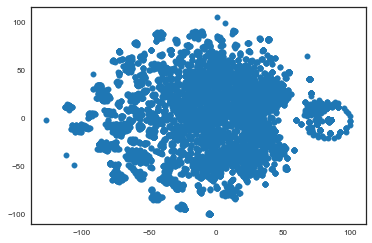

In [83]:
# perp=15
plt.scatter(tsne15[:,0],tsne15[:,1])
# plt.savefig('perp15')

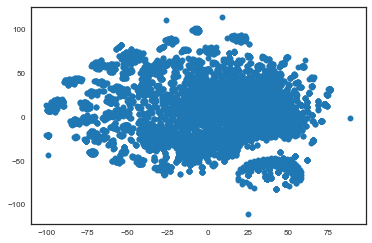

In [84]:
# perp=20
plt.scatter(tsne20[:,0],tsne20[:,1])
# plt.savefig('perp20')

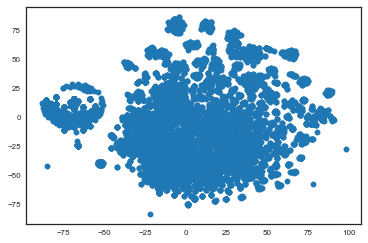

In [78]:
plt.scatter(tsne30[:,0],tsne30[:,1],cmap=plt.cm.viridis)
# plt.savefig('perp30')

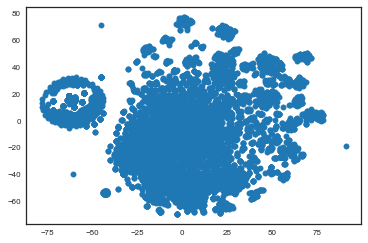

In [85]:
# perp=40
plt.scatter(tsne40[:,0],tsne40[:,1])
# plt.savefig('perp40')

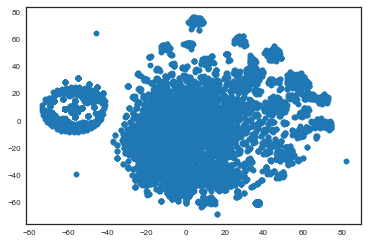

In [86]:
# perp=50
plt.scatter(tsne50[:,0],tsne50[:,1])
# plt.savefig('perp50')

### Clustering 

In typical clustering fashion, we will use K-Means clustering to find the most natural clusters in the data.  We will use the elbow method to determine the proper $k$ for our clustering.  From the below elbow plot, returns on decreasing distance seem to deminish around $k=16$, so we will choose our $k$ to be 16. 

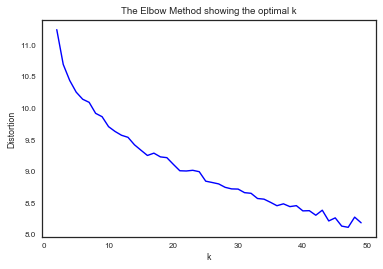

In [118]:
# k means determine k
distortions = []
K = list(range(2,50))
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
 
# plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [15]:
# K means clustering
# Based on the elbow plot above I choose 16 as the k for k-means
clusters = KMeans(n_clusters=16,random_state=9921).fit(X)
clusters.labels_.shape

(8183,)

### Visualization:

Here we color by our $k$ clusters in the TSNE plot with perplexity at 50.

We also present the distribution of the clusters below the colored graph.

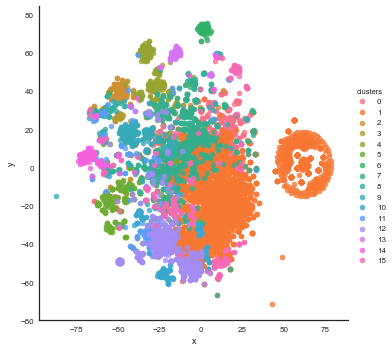

In [19]:
plot_df = pd.DataFrame({'x':tsne50[:,0],'y':tsne50[:,1],'clusters': clusters.labels_})
sns.lmplot(x='x',y='y',hue='clusters', data=plot_df,fit_reg=False)
# plt.savefig('w2v_clusters16_tsne50')

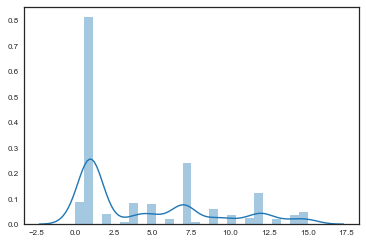

In [18]:
# Distribution of the cluster labels.
sns.distplot(clusters.labels_)

In [20]:
pl_names['cluster'] = clusters.labels_
pl_names = pl_names.drop(['w2v','pl_name'],axis=1)
pl_names.head()

,pl_id,cluster
0,3ftsSOkyCsILZeAZYQr2jH,1
2,35XFuuqgCvTYQARix7CFpm,1
3,0gGfciue2ZDCOG5uMv46gU,11
4,6Tuex6CIDfZRyRtsmb5rwE,7
5,5xL1c6RCMhVDTVLZUsY5SR,1


In [23]:
# Save the feature with playlist ID for later joining
# pl_names.to_json('w2v_feature.json')